✅ TensorFlow Version: 2.19.0
Found 8211 files belonging to 3 classes.
Using 6569 files for training.
Found 8211 files belonging to 3 classes.
Using 1642 files for validation.
Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6667 - loss: 2.3678
Epoch 1: val_accuracy improved from -inf to 0.78258, saving model to models\osteoporosis_resnet50.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.6669 - loss: 2.3612 - val_accuracy: 0.7826 - val_loss: 0.4871
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7714 - loss: 0.5091
Epoch 2: val_accuracy improved from 0.78258 to 0.79781, saving model to models\osteoporosis_resnet50.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.7714 - loss: 0.5090 - val_accuracy: 0.7978 - val_loss: 0.4319
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8226 - loss: 0.4130
Epoch 3: val_accuracy improved from 0.79781 to 0.84166, saving model to models\osteoporosis_resnet50.keras
206/206 ━━━━━━━━━━━

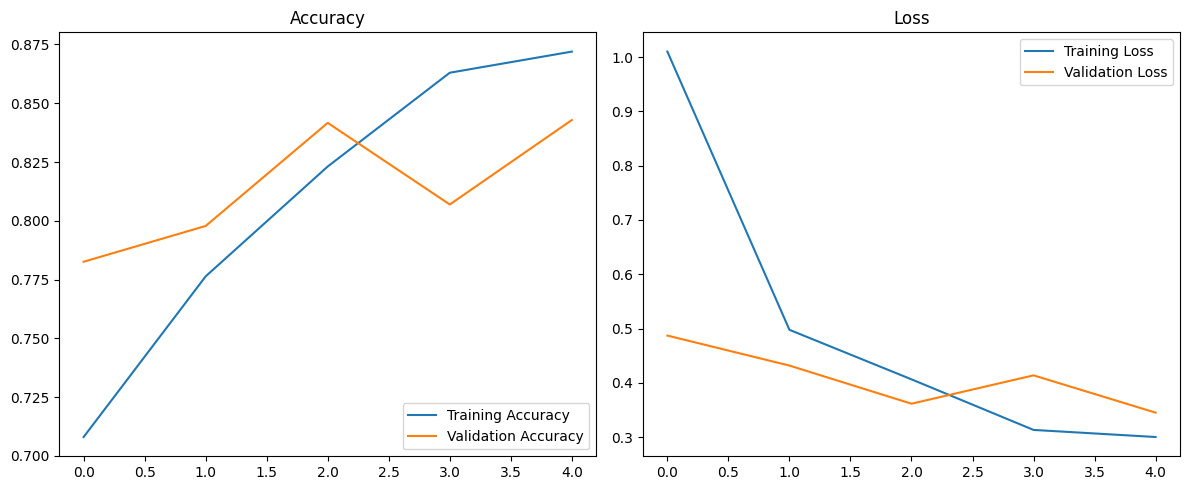

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pathlib

print("✅ TensorFlow Version:", tf.__version__)

# --- Configuration ---
DATASET_PATH = pathlib.Path(r'C:\Users\91947\Desktop\dap and iot\test\result\pro')
MODEL_SAVE_PATH = pathlib.Path('./models')
PLOTS_SAVE_PATH = pathlib.Path('./plots')
MODEL_FILENAME = 'osteoporosis_resnet50.keras'  # Single save file

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 5  # For quick testing
VALIDATION_SPLIT = 0.2
CLASS_NAMES = ['Normal', 'Osteopenia', 'Osteoporosis']
NUM_CLASSES = len(CLASS_NAMES)

MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)
PLOTS_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# --- Dataset Loading ---
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='training'
)

val_ds = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='validation'
)

# Preprocessing
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(tf.data.AUTOTUNE)

# --- Model Definition ---
inputs = keras.Input(shape=IMG_SHAPE)

# ✅ Load ResNet50 first
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False  # Keep pretrained weights frozen

x = base_model(inputs, training=False)

# ✅ Add Convolutional Layers AFTER ResNet50
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# ✅ Add Final Layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# --- Compile Model ---
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=str(MODEL_SAVE_PATH / MODEL_FILENAME),
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1)

# --- Train Model ---
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])

# --- Save Model ---
final_model_path = str(MODEL_SAVE_PATH / MODEL_FILENAME)
model.save(final_model_path)
print(f"✅ Final model saved as: {final_model_path}")

# --- Save Training Plot ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.tight_layout()
plot_path = str(PLOTS_SAVE_PATH / 'training_history.png')
plt.savefig(plot_path)
print(f"📊 Training plot saved to: {plot_path}")
